In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import skimage
import toml
import glob
from tqdm.auto import tqdm
import joblib
import pandas as pd
import seaborn as sns

In [3]:
from qd_analysis.fig import setup_plotting_env

In [4]:
import socket
hostname = socket.gethostname()

config = toml.load("../preprocessing/config.toml")
if "pace" in hostname:
    save_dir = config["dirs"]["analysis"]
    fig_dir = os.path.expanduser("~/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-04 (QD paper round 2)/")
else:
    save_dir = os.path.expanduser("~/Desktop/data/qds_sciadv_rebuttal/quantum_dot_analysis/")

use_joints = False

In [5]:
if use_joints:
    save_file = os.path.join(save_dir, "kpoint_training_dataset_qd_alignment_kneejoints_reflect_only_round2_manual_labeling_nofluo_version-v1.parquet") 
else:
    save_file = os.path.join(save_dir, "kpoint_training_dataset_qd_alignment_round2_manual_labeling_nofluo_version-v1.parquet")     

In [6]:
qd_df = pd.read_parquet(save_file)

In [7]:
tqdm.pandas()

In [8]:
# use all data if on PACE, otherwise trim down for laptop
if "pace" in hostname:
    use_df = qd_df.query("crop_valid").groupby("kpoint_name").sample(2000, random_state=0).copy()
else:
    use_df = qd_df.query("crop_valid").groupby("kpoint_name").sample(2000, random_state=0).copy()
use_df.index = np.arange(len(use_df))

In [9]:
use_df["crop_im"] = use_df["crop_im"].progress_apply(lambda x: np.clip(np.vstack(x).astype("int16"), 0, np.inf))

  0%|          | 0/20000 [00:00<?, ?it/s]

# user functions

In [10]:
use_df["crop_im"].iat[0].shape

(30, 30)

In [11]:
def get_new_center(im, detect_blob=False):
    new_im = im.copy()
    if detect_blob:
        mask = pcl.fluo.get_closest_blob(new_im)
        new_im[mask == 0] = 0

    kpoint_gauss_params, kpoint_moment_params = (
        pcl.fluo.fit_2d_gaussian_with_moments(
            new_im, loss="linear",
        )
    )
    kpoint_com = [
        kpoint_moment_params["x0"],
        kpoint_moment_params["y0"],
        kpoint_moment_params["sigma_x"],
        kpoint_moment_params["sigma_y"]
    ]

    if kpoint_gauss_params is not None:
        kpoint_com_gauss = [
            kpoint_gauss_params["x0"],
            kpoint_gauss_params["y0"],
            kpoint_gauss_params["sigma_x"],
            kpoint_gauss_params["sigma_y"],
        ]
    else:
        kpoint_com_gauss = [np.nan, np.nan, np.nan, np.nan]
    return {"com": kpoint_com, "com_gauss": kpoint_com_gauss}

# apply different methods here...
1. CoM
2. Gauss CoM
3. Blob detected CoM
4. Blob detected Gauss CoM

In [12]:
from markovids import pcl

In [13]:
from scipy.ndimage import shift

In [14]:
no_blob_com = use_df["crop_im"].progress_apply(lambda x: get_new_center(x, detect_blob=False))
blob_com = use_df["crop_im"].progress_apply(lambda x: get_new_center(x, detect_blob=True))

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [15]:
shift_kwargs = {"mode": "constant", "cval": 0.0}

In [16]:
use_df["crop_im_com_no_blob"] = None
use_df["crop_im_com_gauss_no_blob"] = None
use_df["crop_im_com_blob"] = None
use_df["crop_im_com_gauss_blob"] = None

body_parts = sorted(use_df["kpoint_name"].unique())
im_shape = use_df["crop_im"].iat[0].shape
center_y, center_x = im_shape[0] // 2, im_shape[1] // 2

for i in tqdm(range(len(use_df))):
    
    x1 = np.isnan(no_blob_com.iloc[i]["com"]).any()
    x2 = np.isnan(no_blob_com.iloc[i]["com_gauss"]).any()
    x3 = np.isnan(blob_com.iloc[i]["com_gauss"]).any()
    x4 = np.isnan(blob_com.iloc[i]["com_gauss"]).any()

    if x1 or x2 or x3 or x4:
        continue
    
    im = use_df["crop_im"].iat[i]
    _part = use_df["kpoint_name"].iat[i]

    use_shift = [
        center_y - no_blob_com.iloc[i]["com"][1],
        center_x - no_blob_com.iloc[i]["com"][0],
    ]

    use_df.at[i, "fit_sigma_x_com_no_blob"] = no_blob_com.iloc[i]["com"][2]
    use_df.at[i, "fit_sigma_y_com_no_blob"] = no_blob_com.iloc[i]["com"][3]
    use_df.at[i,"crop_im_com_no_blob"] = shift(im, use_shift, **shift_kwargs)
    
    use_shift = [
        center_y - no_blob_com.iloc[i]["com_gauss"][1],
        center_x - no_blob_com.iloc[i]["com_gauss"][0],
    ]

    use_df.at[i, "fit_sigma_x_com_gauss_no_blob"] = no_blob_com.iloc[i]["com_gauss"][2]
    use_df.at[i, "fit_sigma_y_com_gauss_no_blob"] = no_blob_com.iloc[i]["com_gauss"][3]
    use_df.at[i,"crop_im_com_gauss_no_blob"] = shift(im, use_shift, **shift_kwargs)
    
    use_shift = [
        center_y - blob_com.iloc[i]["com"][1],
        center_x - blob_com.iloc[i]["com"][0],
    ]

    use_df.at[i, "fit_sigma_x_com_blob"] = blob_com.iloc[i]["com"][2]
    use_df.at[i, "fit_sigma_y_com_blob"] = blob_com.iloc[i]["com"][3]
    use_df.at[i,"crop_im_com_blob"] = shift(im, use_shift, **shift_kwargs)

    use_shift = [
        center_y - blob_com.iloc[i]["com_gauss"][1],
        center_x - blob_com.iloc[i]["com_gauss"][0],
    ]

    use_df.at[i, "fit_sigma_x_com_gauss_blob"] = blob_com.iloc[i]["com_gauss"][2]
    use_df.at[i, "fit_sigma_y_com_gauss_blob"] = blob_com.iloc[i]["com_gauss"][3]
    use_df.at[i,"crop_im_com_gauss_blob"] = shift(im, use_shift, **shift_kwargs)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [17]:
show_pixels = slice(center_y - 15, center_y + 15)
cmap_kwargs = {"vmin": 0, "vmax": 165, "cmap": "turbo"}

In [19]:
# for _part in body_parts:
#     fig, ax = plt.subplots(2, 3, figsize=(6,4), sharex=True, sharey=True)
#     for rax, _blob in zip(ax, ["no_blob","blob"]):
#         for _ax, _com in zip(rax[1:], ["com","com_gauss"]):
#             key = f"{_blob}_{_com}"
#             h = _ax.imshow(np.mean(shift_ims[key][_part],axis=0)[show_pixels][:,show_pixels], **cmap_kwargs) 
#             _ax.axis("off")
#             _ax.set_title(key)
#     ax[0][0].imshow(np.mean(shift_ims["raw"][_part],axis=0)[show_pixels][:,show_pixels], **cmap_kwargs) 
#     ax[1][0].axis("off")
#     fig.suptitle(_part)
#     fig.colorbar(h, ax=ax.ravel(), shrink=.5)

# For simplicity combine, back, paws and tail

In [22]:
import cmocean

In [23]:
# now combine back, tail, paws
segments = {}
segments["back"]  = ["back_bottom","back_middle","back_top"]
segments["paws"]  = ["foreleg_L", "foreleg_R", "hindleg_L", "hindleg_R"]
segments["tail"]  = ["tail_base", "tail_middle", "tail_tip"]
map_body_part_to_segment = {}
for k, v in segments.items():
    for _v in v:
        map_body_part_to_segment[_v] = k

In [24]:
use_df["segment"] = use_df["kpoint_name"].map(map_body_part_to_segment)

In [25]:
aliases = {"crop_im": "original",
           "crop_im_com_no_blob": "CoM",
           "crop_im_com_blob": "CoM + Cleanup",
           "crop_im_com_gauss_no_blob": "Gauss.",
           "crop_im_com_gauss_blob": "Gauss. + Cleanup"} # aliases for plotting im keys

In [26]:
plt_order = ["crop_im", "crop_im_com_no_blob", "crop_im_com_blob", "crop_im_com_gauss_no_blob", "crop_im_com_gauss_blob"]
segments_im = {_k: use_df.groupby("segment")[_k].mean() for _k in plt_order}

In [27]:
nrows = len(segments_im)
ncols = len(list(segments_im.values())[0])

In [28]:
show_pixels = slice(center_y - 15, center_y + 15)
# cmap_kwargs = {"vmin": 0, "vmax": 150, "cmap": cmocean.cm.ice}
cmap_kwargs = {"vmin": 0, "vmax": 150, "cmap": "inferno"}

In [29]:
setup_plotting_env()

In [30]:
base_palette = sns.color_palette("tab10", n_colors=len(plt_order))

In [31]:
# make a palette, use for borders, boxplots, etc.
palette = dict(list(zip(plt_order, base_palette)))

In [32]:
palette

{'crop_im': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'crop_im_com_no_blob': (1.0, 0.4980392156862745, 0.054901960784313725),
 'crop_im_com_blob': (0.17254901960784313,
  0.6274509803921569,
  0.17254901960784313),
 'crop_im_com_gauss_no_blob': (0.8392156862745098,
  0.15294117647058825,
  0.1568627450980392),
 'crop_im_com_gauss_blob': (0.5803921568627451,
  0.403921568627451,
  0.7411764705882353)}

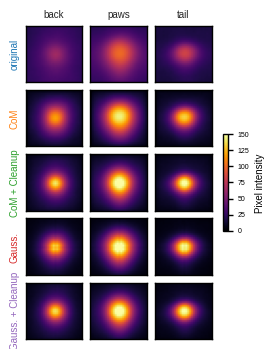

In [65]:
fig, ax = plt.subplots(nrows, ncols, figsize=(1 * ncols, 1 * nrows), sharex=True, sharey=True)
for rax, (com_type, ims) in zip(ax, segments_im.items()):
    for _ax, (body_part, im) in zip(rax, ims.items()):
        h =_ax.imshow(im[show_pixels][:, show_pixels], **cmap_kwargs)
        row = _ax.get_subplotspec().rowspan.start
        col = _ax.get_subplotspec().colspan.start
        if row == 0:
            _ax.set_title(body_part)
        if col == 0:
            _ax.set_ylabel(aliases[com_type], color=palette[com_type])
        _ax.set_xticks([])
        _ax.set_yticks([])
        # for k, v in _ax.spines.items():
        #     _ax.spines[k].set_color(palette[com_type])
        #     _ax.spines[k].set_linewidth(2.5)
            # v.set_color(palette[com_type])
fig.subplots_adjust(hspace=-.5, wspace=0.15)
cbar = fig.colorbar(h, ax=ax.ravel(), shrink=.25)
cbar.set_label("Pixel intensity")
fig.savefig(os.path.join(fig_dir, "centroid_strategy_visualization.pdf"), bbox_inches="tight", dpi=600)
# _ax.axis("off")

In [42]:
plt_order = ["crop_im", "crop_im_com_no_blob", "crop_im_com_blob", "crop_im_com_gauss_no_blob", "crop_im_com_gauss_blob"]
# segments_im = {_k: use_df.groupby("segment")[_k].mean() for _k in plt_order}

In [43]:
def get_radial_profile(image, center=None, binsize=1):
    y, x = np.indices(image.shape)

    if center is None:
        center = image.shape[1] // 2, image.shape[0] // 2

    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = np.round((r *  1 / binsize)).astype(np.int32)

    r_max = int(r.max()) + 1
    radial_mean = np.bincount(r.ravel(), image.ravel()) / np.bincount(r.ravel())
    
    return np.arange(len(radial_mean)) * binsize, radial_mean

In [44]:
ave_segments = use_df.groupby(["segment","kpoint_avi_fname"])[plt_order].mean()
ave_segments_radial_profile = ave_segments.map(lambda x: get_radial_profile(x, binsize=.5))
index_names = ave_segments_radial_profile.index.names

/tmp/ipykernel_2831505/4155812931.py:11: RuntimeWarning: invalid value encountered in divide
  radial_mean = np.bincount(r.ravel(), image.ravel()) / np.bincount(r.ravel())


In [45]:
dfs = []
for k, v in ave_segments_radial_profile.iterrows():
    for _crop_type, (_bins, _bin_means) in v.items():
        _df = pd.DataFrame()
        _df["bin"] = _bins
        _df["bin_mean"] = _bin_means
        _df["crop_type"] = aliases[_crop_type]
        for _key_name, _key_value in zip(index_names, k):
            _df[_key_name] = _key_value
        dfs.append(_df)

In [46]:
radial_df = pd.concat(dfs, ignore_index=True)

In [47]:
def get_snr(df, right_edge=None, left_edge=2):
    if right_edge is None:
        right_edge = df["bin"].max() - 2
    df_peak = df.loc[df["bin"]<left_edge]
    df_noise = df.loc[(df["bin"]>right_edge)]
    return df_peak["bin_mean"].mean()
    # return df_peak["bin_mean"].mean() / df_noise["bin_mean"].mean()

In [48]:
def get_halfway(df, resolution=.1, interpolate_kwargs={"method":"slinear"}): 
    new_series = pd.Series(data=df["bin_mean"].values, index=df["bin"].values).sort_index()
    new_series = new_series.reindex(np.arange(0, len(new_series), resolution))
    new_series = new_series.interpolate(**interpolate_kwargs)
    peak_value = new_series.loc[0]
    for k, v in new_series.items():
        if v<=(peak_value*.5):
            return k
    return np.nan
        

In [49]:
radial_df_snr = (
    radial_df.groupby(["crop_type", "segment", "kpoint_avi_fname"])
    .apply(lambda x: get_snr(x, right_edge=15, left_edge=.5))
    .rename("snr")
    .reset_index()
)

/tmp/ipykernel_2831505/3249359716.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: get_snr(x, right_edge=15, left_edge=.5))


In [50]:
radial_df_halfway = radial_df.groupby(["crop_type","segment","kpoint_avi_fname"]).apply(get_halfway).rename("halfway").reset_index() 

/tmp/ipykernel_2831505/512710509.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  radial_df_halfway = radial_df.groupby(["crop_type","segment","kpoint_avi_fname"]).apply(get_halfway).rename("halfway").reset_index()


In [51]:
snr_order = radial_df_snr.groupby("crop_type")["snr"].median().sort_values()[::-1].index
halfway_order = radial_df_halfway.groupby("crop_type")["halfway"].median().sort_values().index

In [52]:
kwargs = {"x": "crop_type",
          "hue": "crop_type",
          "showcaps": False,
          "showfliers": False,}

In [57]:
palette_aliases = { aliases[k]: v for k, v in palette.items() }

/tmp/ipykernel_2831505/2870046779.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(_ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2831505/2870046779.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(_ax.get_xticklabels(), rotation=45, ha='right')


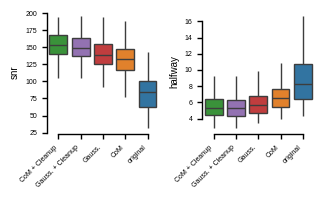

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(3.25,2))
sns.boxplot(data=radial_df_snr,
            order=snr_order,
            y="snr",
            ax=ax[0],
            hue_order=snr_order,
            palette=palette_aliases,
            **kwargs)
sns.boxplot(data=radial_df_halfway,
            y="halfway",
            order=halfway_order,
            hue_order=snr_order,
            palette=palette_aliases,
            **kwargs)
for _ax in ax:
    # _ax.tick_params(axis="x", rotation=45)
    _ax.set_xticklabels(_ax.get_xticklabels(), rotation=45, ha='right')
    _ax.set_xlabel("")
sns.despine(trim=True)
fig.tight_layout()
fig.savefig(os.path.join(fig_dir, "centroid_strategy_snr-and-halfpointdecay.pdf"), bbox_inches="tight", dpi=600)

In [60]:
from qd_analysis.fig import setup_plotting_env

In [61]:
setup_plotting_env()

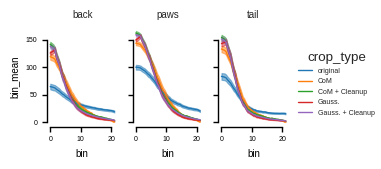

In [63]:
g = sns.relplot(data=radial_df,
            x="bin",
            y="bin_mean",
            col="segment",
            hue="crop_type",
            palette=palette_aliases,
            kind="line",
            height=1.7,
            aspect=.6,
            err_kws={"alpha": .5},
            errorbar=("ci",95))
sns.despine(trim=True)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.fig.savefig(os.path.join(fig_dir, "centroid_strategy_radial_profile.pdf"), bbox_inches="tight", dpi=600)

# Simulate uncertainty in detecting the peak

In [ ]:
from sklearn.model_selection import ParameterGrid
import warnings
from copy import deepcopy

In [ ]:
def generate_gaussian_blob(size=30, amplitude=12.0, center=None, sigma_x=6.0, sigma_y=7.0, noise_std=3.0):
    """Generate a 2D Gaussian blob image with optional Gaussian noise."""
    x = np.arange(size)
    y = np.arange(size)
    xx, yy = np.meshgrid(x, y)

    if center is None:
        center = (size // 2, size // 2)
    x0, y0 = center

    blob = amplitude * np.exp(
        -(((xx - x0)**2) / (2 * sigma_x**2) + ((yy - y0)**2) / (2 * sigma_y**2))
    )

    if noise_std > 0:
        blob += np.random.normal(0, noise_std, blob.shape)

    return blob

In [ ]:
grid_dct = {
    "amplitude": [15],
    "noise_std": np.arange(.5, 3, .25),
    "sigma": np.arange(4, 16, 1.),
    "aspect_ratio": np.arange(1., 2.01, .25)
}


In [ ]:
nrepeats = 100

In [ ]:
param_grid = ParameterGrid(grid_dct)

In [ ]:
save_file = os.path.join(config["dirs"]["analysis"], "peak_location_uncertainty_simulations.parquet")

In [ ]:
force = False

In [ ]:
if not os.path.exists(save_file) or force:
    dcts = []
    for _params in tqdm(param_grid):
        use_params = deepcopy(_params)
        sigma_x, sigma_y = use_params["sigma"], use_params["sigma"]
        sigma_x = use_params["aspect_ratio"] * sigma_x
        use_params.pop("sigma")
        use_params.pop("aspect_ratio")
        for _repeat in range(nrepeats):
            im = generate_gaussian_blob(**use_params, sigma_x=sigma_x, sigma_y=sigma_y)
            cx, cy = im.shape[1] // 2, im.shape[0] // 2
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                gauss_params, com_params = pcl.fluo.fit_2d_gaussian_with_moments(im)
            _dct = {}
            for k, v in _params.items():
                _dct[k] = v
            if gauss_params is not None:
                _dct["gauss_error"] = np.linalg.norm([gauss_params["x0"] - cx, gauss_params["y0"] - cy])
                _dct["com_error"] = np.linalg.norm([com_params["x0"] - cx, com_params["y0"] - cy])
            else:
                _dct["gauss_error"] = np.nan
                _dct["com_error"] = np.nan
            _dct["repeat"] = _repeat
            dcts.append(_dct)
    peak_df = pd.DataFrame(dcts)
    peak_df.to_parquet(save_file)
else:
    peak_df = pd.read_parquet(save_file)

In [ ]:
agg_columns = list(grid_dct.keys())

In [ ]:
peak_df["snr"] = (peak_df["amplitude"] / peak_df["noise_std"]).round(1)

In [ ]:
agg_columns += ["snr"]

In [ ]:
agg_df = peak_df.groupby(agg_columns).quantile(.95)

In [ ]:
pairs = [
    ["snr","sigma"],
    ["snr","aspect_ratio"]
]

In [ ]:
setup_plotting_env()

In [ ]:
kwargs = {"cmap": "viridis",
          # "center": 5,
          # "vmin": 0,
          # "vmax": 10}
          "norm": plt.matplotlib.colors.LogNorm(vmin=.1, vmax=100)}

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(3.25,2.75))
cbar_ax = fig.add_axes([.93, .3, .02, .3])
for i, (rax, _pair) in enumerate(zip(ax, pairs)):
    h1 = sns.heatmap(
        agg_df.groupby(_pair)["gauss_error"].min().unstack(),
        **kwargs,
        ax=rax[0],
        cbar=False,
    )
    h2 = sns.heatmap(
        agg_df.groupby(_pair)["gauss_error"].max().unstack(),
        **kwargs,
        ax=rax[1],
        cbar_ax=cbar_ax,
        cbar=i==0,
    )

    if i == 0:
        rax[0].set_title("Min projection")
        rax[1].set_title("Max projection")

# cbar_ax.set_frame_on(True)
cbar_ax.spines["outline"].set(visible=True, lw=.8, edgecolor="black")

for _ax in ax.ravel():
    _ax.invert_yaxis()
    # colors = _ax.collections[0].get_facecolors()
    # _ax.collections[0].set_edgecolors(colors)
fig.tight_layout(rect=[0, 0, .93, 1])
fig.savefig(os.path.join(fig_dir, "centroid_uncertainty_sim_heatmap.pdf"), bbox_inches="tight", dpi=600)

In [ ]:
cmap = plt.colormaps["turbo"]
over = cmap.colors[-1]
kwargs = {"levels": [0, .5, 1, 1.5, 2, 2.5, 3],
          "cmap": cmap,
          "extend": "max"}

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(3.25,2.75), sharex="row", sharey="row")
for i, (rax, _pair) in enumerate(zip(ax, pairs)):

    im_min = agg_df.groupby(_pair)["gauss_error"].min().unstack()
    X, Y = np.meshgrid(im_min.columns, im_min.index)
    CS = rax[0].contourf(X, Y, im_min.values, **kwargs)
    CS.cmap.set_under("b")
    CS.cmap.set_over(over)

    im_max = agg_df.groupby(_pair)["gauss_error"].max().unstack()
    CS = rax[1].contourf(X, Y, im_max.values, **kwargs)
    CS.cmap.set_under("b")
    CS.cmap.set_over(over)

    if i == 0:
        rax[0].set_title("Min projection")
        rax[1].set_title("Max projection")
    
    rax[0].set_xlabel(_pair[1])
    rax[1].set_xlabel(_pair[1])    
    rax[0].set_ylabel(_pair[0])

fig.tight_layout()
fig.colorbar(CS, ax=ax.ravel().tolist(), shrink=.7, pad=.05)
fig.savefig(os.path.join(fig_dir, "centroid_uncertainty_sim_contours.pdf"), bbox_inches="tight", dpi=600)